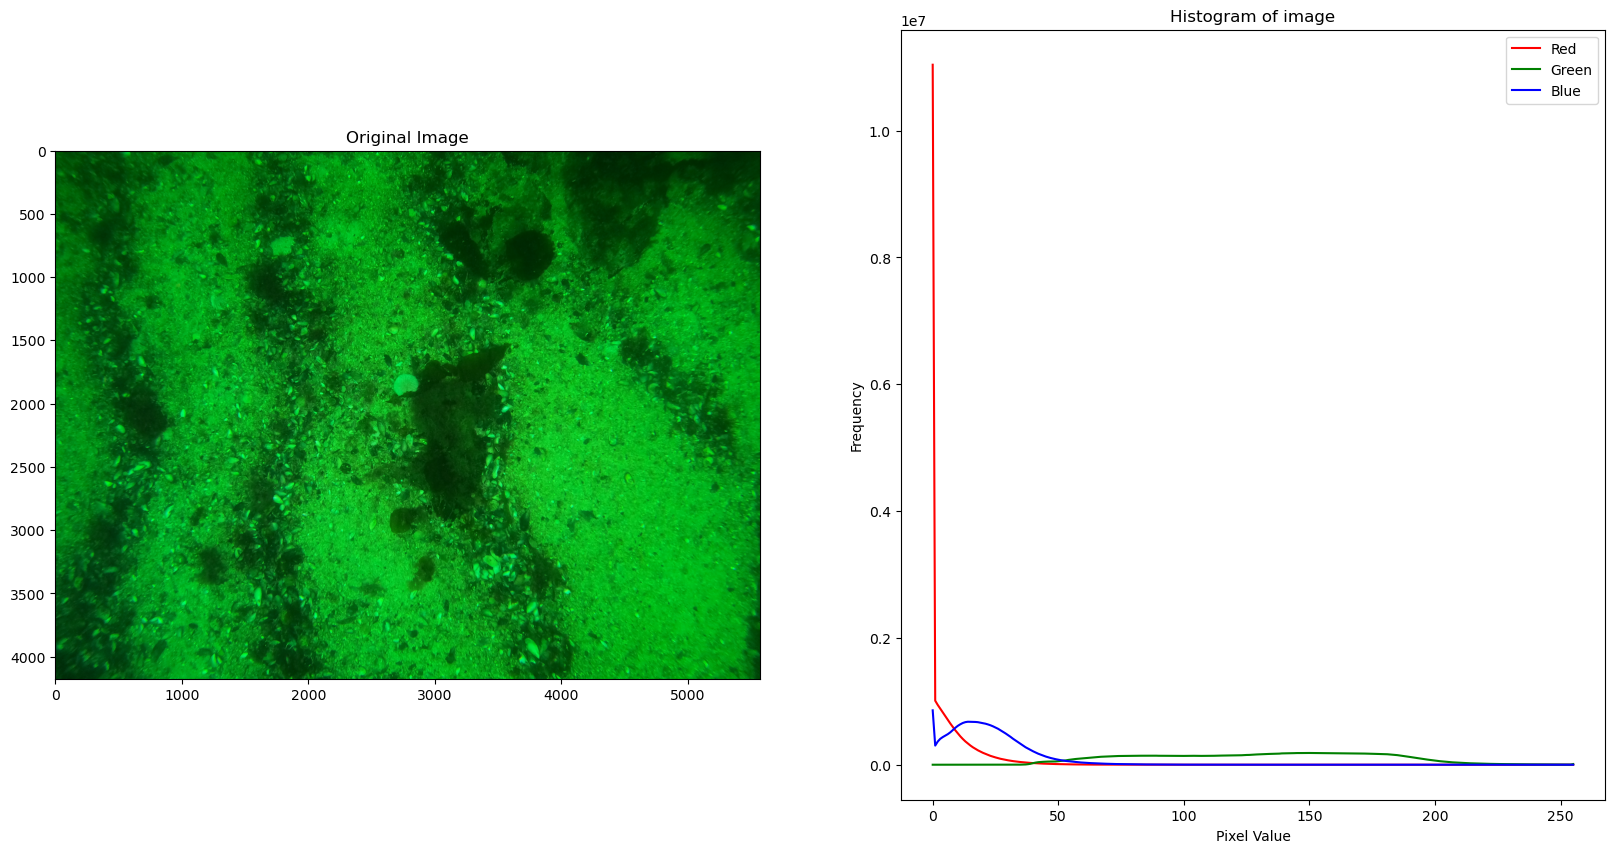

In [6]:
# Plotting the histograms of each channel of image
import os
from PIL import Image
from matplotlib import pyplot as plt

def plot_histogram(image):
    # Split the R, G and B channels
    imageR, imageG, imageB = image.split()
    
    # Plot the histograms
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Histogram of image")
    
    # Plot the histograms with labels
    plt.plot(imageR.histogram(), color='red', label='Red')
    plt.plot(imageG.histogram(), color='green', label='Green')
    plt.plot(imageB.histogram(), color='blue', label='Blue')
    
    # Add labels to the x and y axes
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # Add a legend to indicate the color channels
    plt.legend()
    
    plt.show()

def process_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            plot_histogram(image)

if __name__ == "__main__":
    input_folder = (r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_Raw")
    process_images_in_folder(input_folder)

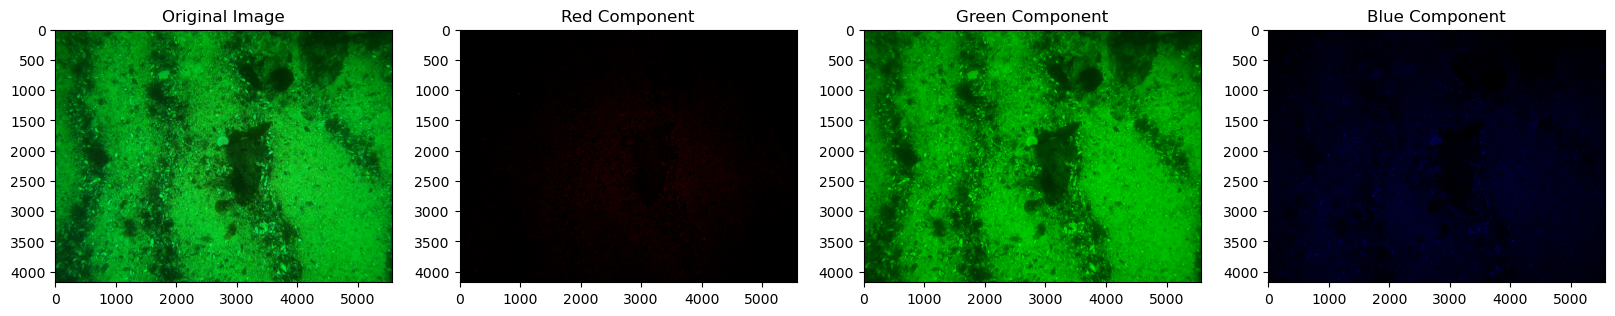

In [2]:
# Plotting R, G, and B components of the image
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def channel_split(image):
    # Split the R, G, and B channels
    imageR, imageG, imageB = image.split()
    x, y = image.size
    Rchannel = np.zeros((y, x, 3), dtype="uint8")
    Bchannel = np.zeros((y, x, 3), dtype="uint8")
    Gchannel = np.zeros((y, x, 3), dtype="uint8")
    # Create individual components image
    Rchannel[:, :, 0] = imageR
    Bchannel[:, :, 1] = imageG
    Gchannel[:, :, 2] = imageB
    # Convert array to image
    Rchannel = Image.fromarray(Rchannel)
    Bchannel = Image.fromarray(Bchannel)
    Gchannel = Image.fromarray(Gchannel)

    # Plot R, G, and B components
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 4, 2)
    plt.title("Red Component")
    plt.imshow(Rchannel)
    plt.subplot(1, 4, 3)
    plt.title("Green Component")
    plt.imshow(Bchannel)
    plt.subplot(1, 4, 4)
    plt.title("Blue Component")
    plt.imshow(Gchannel)
    plt.show()

def process_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            channel_split(image)

if __name__ == "__main__":
    input_folder = (r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_Raw")
    process_images_in_folder(input_folder)

In [18]:
import os
from PIL import Image, ImageFilter
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Specify input and output folders
input_folder = r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_Raw"  # Replace with your input folder path
output_folder = r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_processed\\With_compensationRB\\no_sf"  # Replace with your output folder path

#1. R+B compensation from pranjalibajpai (modified by GBT - use NumPy arrays, precompute min and max values, vectoriezed operations, removed visulisation = 6 images in 3.8s )
# flag = 0 for Red, Blue Compensation via green channel
# flag = 1 for Red Compensation via green channel
#def compensate_RB(image, flag, scaling_factor=2.0):
def compensate_RB(image, flag):

    # Splitting the image into R, G and B components
    imager, imageg, imageb = image.split()
    # Convert to array
    imageR = np.array(imager, dtype=np.float64)
    imageG = np.array(imageg, dtype=np.float64)
    imageB = np.array(imageb, dtype=np.float64)

    minR, maxR = imageR.min(), imageR.max()
    minG, maxG = imageG.min(), imageG.max()
    minB, maxB = imageB.min(), imageB.max()

    imageR = (imageR - minR) / (maxR - minR)
    imageG = (imageG - minG) / (maxG - minG)
    imageB = (imageB - minB) / (maxB - minB)
    # Getting the mean of each channel
    meanR = np.mean(imageR)
    meanG = np.mean(imageG)
    meanB = np.mean(imageB)

    if flag == 0:
        
        #imageR = (imageR + scaling_factor * (meanG - meanR) * (1 - imageR) * imageG) * maxR
        imageR = (imageR + (meanG - meanR) * (1 - imageR) * imageG) * maxR
        #imageB = (imageB + scaling_factor * (meanG - meanB) * (1 - imageB) * imageG) * maxB
        imageB = (imageB + (meanG - meanB) * (1 - imageB) * imageG) * maxB
        imageG = imageG * maxG

    if flag == 1:
        #imageR = (imageR + scaling_factor * (meanG - meanR) * (1 - imageR) * imageG) * maxR
        imageR = (imageR + (meanG - meanR) * (1 - imageR) * imageG) * maxR
        imageB = imageB * maxB
        imageG = imageG * maxG

    compensateIm = np.stack((imageR, imageG, imageB), axis=-1).astype(np.uint8)

    return Image.fromarray(compensateIm)

#2. Better approach to gray world - than GBT's attempt (quicker -  threadpoolexecutor taken from GBT), taken from pranjalibajpai notebook 
def gray_world(image):
    # Convert to NumPy array
    image_array = np.array(image)

    # Separate color channels
    b, g, r = cv2.split(image_array)

    # Calculate the mean of each channel
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)
    mean_gray = np.mean(image_array)

    # Gray World Algorithm
    corrected_b = (b * mean_gray / mean_b).clip(0, 255).astype(np.uint8)
    corrected_g = (g * mean_gray / mean_g).clip(0, 255).astype(np.uint8)
    corrected_r = (r * mean_gray / mean_r).clip(0, 255).astype(np.uint8)

    # Merge the corrected channels
    corrected_image = cv2.merge((corrected_b, corrected_g, corrected_r))

    return Image.fromarray(corrected_image)

#3. Image Sharpening Of White Balanced Image (pytorch approach (using pytorch/GPU's))
# Check if CUDA (GPU support) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to perform image sharpening using PyTorch with an adjustable Gaussian blur radius
def sharpen_with_gpu(wbimage, blur_radius=0.5):
    # Convert PIL image to a PyTorch tensor on the GPU
    wbimage = wbimage.convert("RGB")
    wbimage = torch.from_numpy(np.array(wbimage)).to(device)
    wbimage = wbimage.permute(2, 0, 1).unsqueeze(0).float() / 255.0

    # Adjust the Gaussian blur radius if needed (using PIL)
    smoothed_image = Image.fromarray((wbimage[0] * 255.0).byte().permute(1, 2, 0).cpu().numpy())
    smoothed_image = smoothed_image.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    smoothed_image = torch.from_numpy(np.array(smoothed_image)).to(device)
    smoothed_image = smoothed_image.permute(2, 0, 1).unsqueeze(0).float() / 255.0

    # Perform unsharp masking on the GPU
    sharpened_image = 2 * wbimage - smoothed_image

    # Copy the result back to CPU and convert to PIL image
    sharpened_image = sharpened_image.squeeze().permute(1, 2, 0).cpu().numpy()
    sharpened_image = Image.fromarray((sharpened_image * 255.0).astype(np.uint8))

    return sharpened_image

#4 Contrast enhancement of white balanced image by Global Histogram Equalization
# Function for contrast enhancement using adaptive histogram equalization on the Value channel
def hsv_adaptive_equalization(image, clipLimit=0.8, tileGridSize=(8, 8)):
    # Convert to HSV
    hsvimage = image.convert('HSV')

    # Splitting the Hue, Saturation, and Value components
    Hue, Saturation, Value = hsvimage.split()

    # Convert the Value channel to a numpy array
    value_array = np.array(Value)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the Value channel
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    enhanced_value = clahe.apply(value_array)

    # Convert the enhanced Value channel back to a PIL Image
    enhanced_value_image = Image.fromarray(enhanced_value)

    # Replace the original Value channel with the enhanced Value channel
    hsvimage = Image.merge('HSV', (Hue, Saturation, enhanced_value_image))

    # Convert the HSV image back to RGB
    rgbimage = hsvimage.convert('RGB')

    return rgbimage

# Step 5: Fusion of Sharpened and Contrast-Enhanced Image (Average Fusion)
# Function for average fusion of two images
def average_fusion(image1, image2, output_path):
    # Convert images to NumPy arrays
    image1_array = np.array(image1, dtype=np.float64)
    image2_array = np.array(image2, dtype=np.float64)

    # Perform fusion by averaging the pixel values
    fused_array = (image1_array + image2_array) / 2

    # Convert the fused NumPy array back to an image
    fused_image = Image.fromarray(fused_array.astype('uint8'))
    fused_image.save(output_path)
    print(f"Processed image: {output_path}")

# Process images with error handling
def process_image(input_path, output_path):
    try:
        # Attempt to open and process the image
        input_image = Image.open(input_path)
        #compensated_image = compensate_RB(input_image, flag=0, scaling_factor=2.0)
        compensated_image = compensate_RB(input_image, flag=0)
        gw_image = gray_world(compensated_image)
        #gw_image = gray_world(input_image)
        sharpened_image = sharpen_with_gpu(gw_image, blur_radius=0.5)
        enhanced_image = hsv_adaptive_equalization(gw_image, clipLimit=0.8, tileGridSize=(8, 8))
        average_fusion(sharpened_image, enhanced_image, output_path)
    except Exception as e:
        print(f"Error processing image {input_path}: {e}")

# Process images with error handling
def process_images_with_error_handling(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    valid_extensions = ('.jpg', '.JPG', '.jpeg', '.png', '.gif')
    image_files = [file_name for file_name in os.listdir(input_folder) if file_name.lower().endswith(valid_extensions)]

    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        for image_file in image_files:
            input_path = os.path.join(input_folder, image_file)
            output_path = os.path.join(output_folder, image_file)
            executor.submit(process_image, input_path, output_path)

# Process images with error handling
if __name__ == "__main__":
    process_images_with_error_handling(input_folder, output_folder)



Processed image: Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_processed\\With_compensationRB\\no_sf\Rename_Left_G0047756_T2_100m.JPG


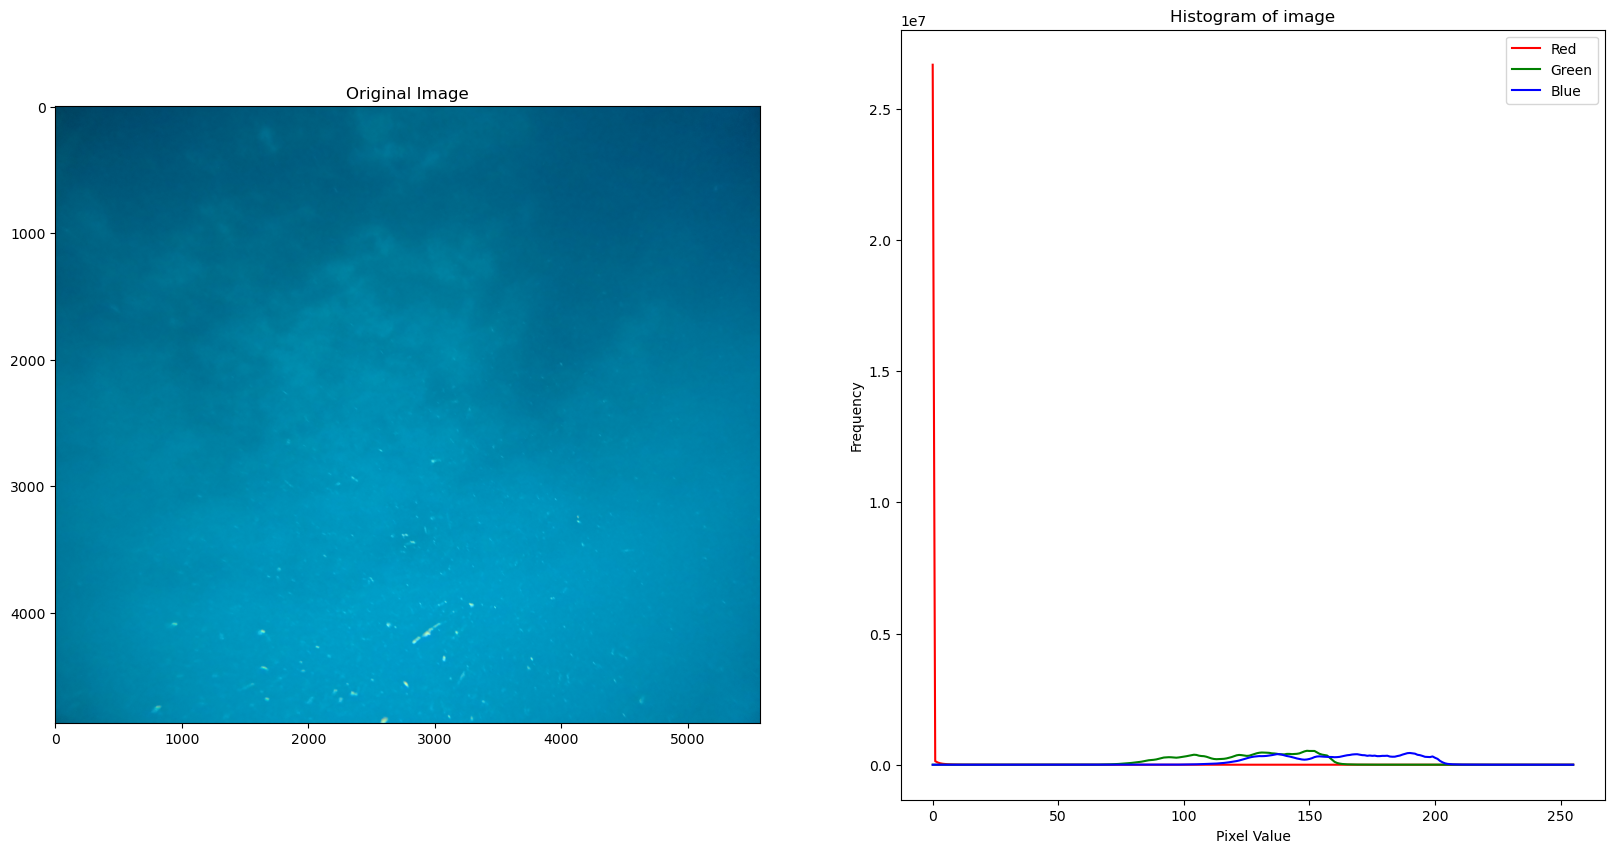

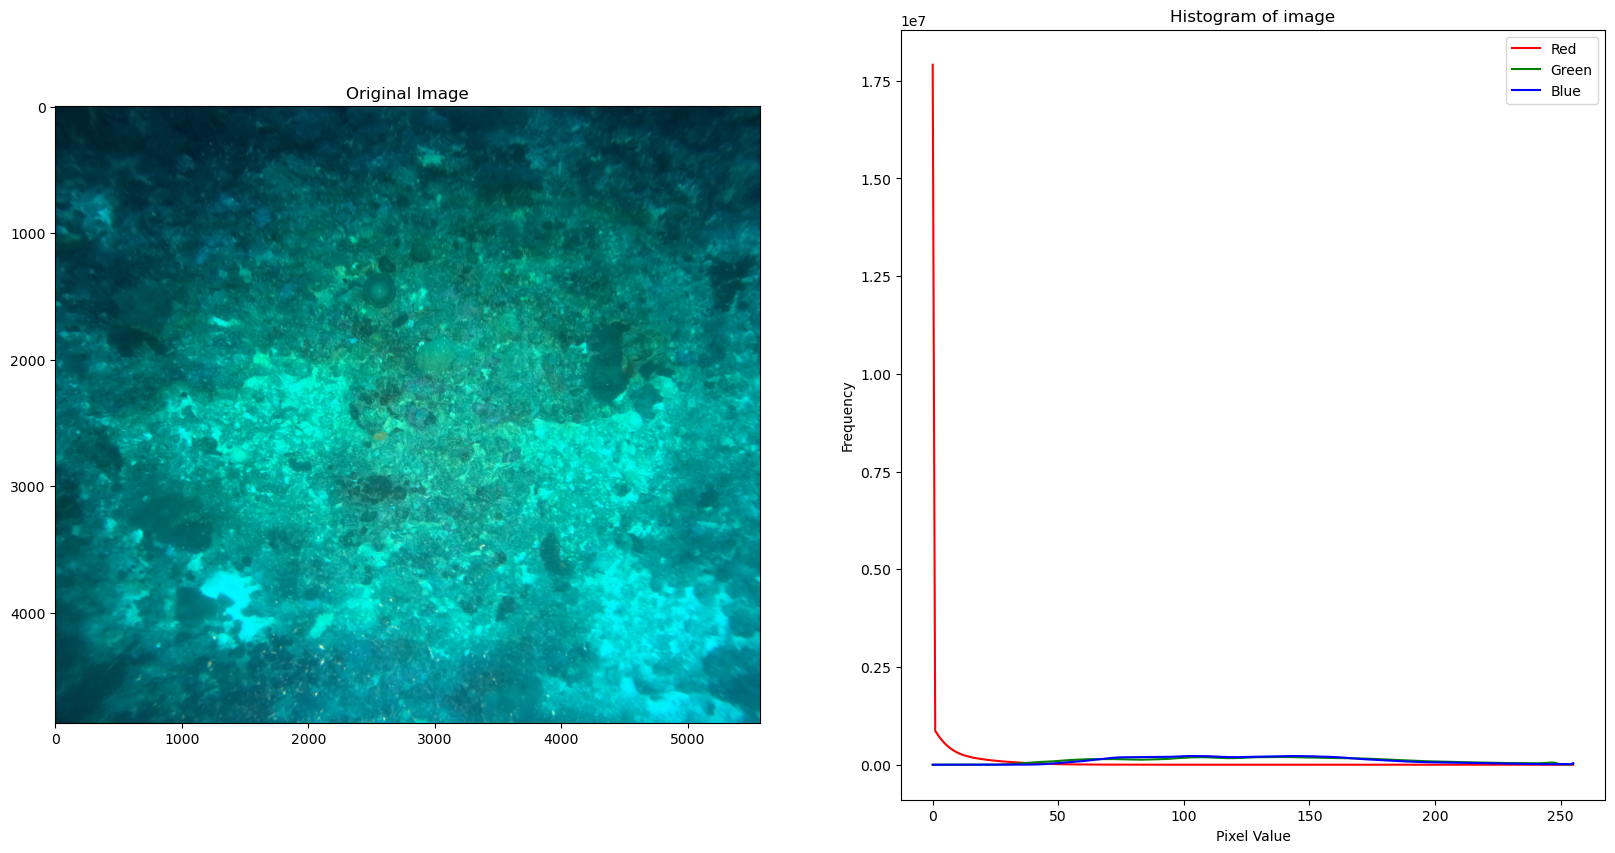

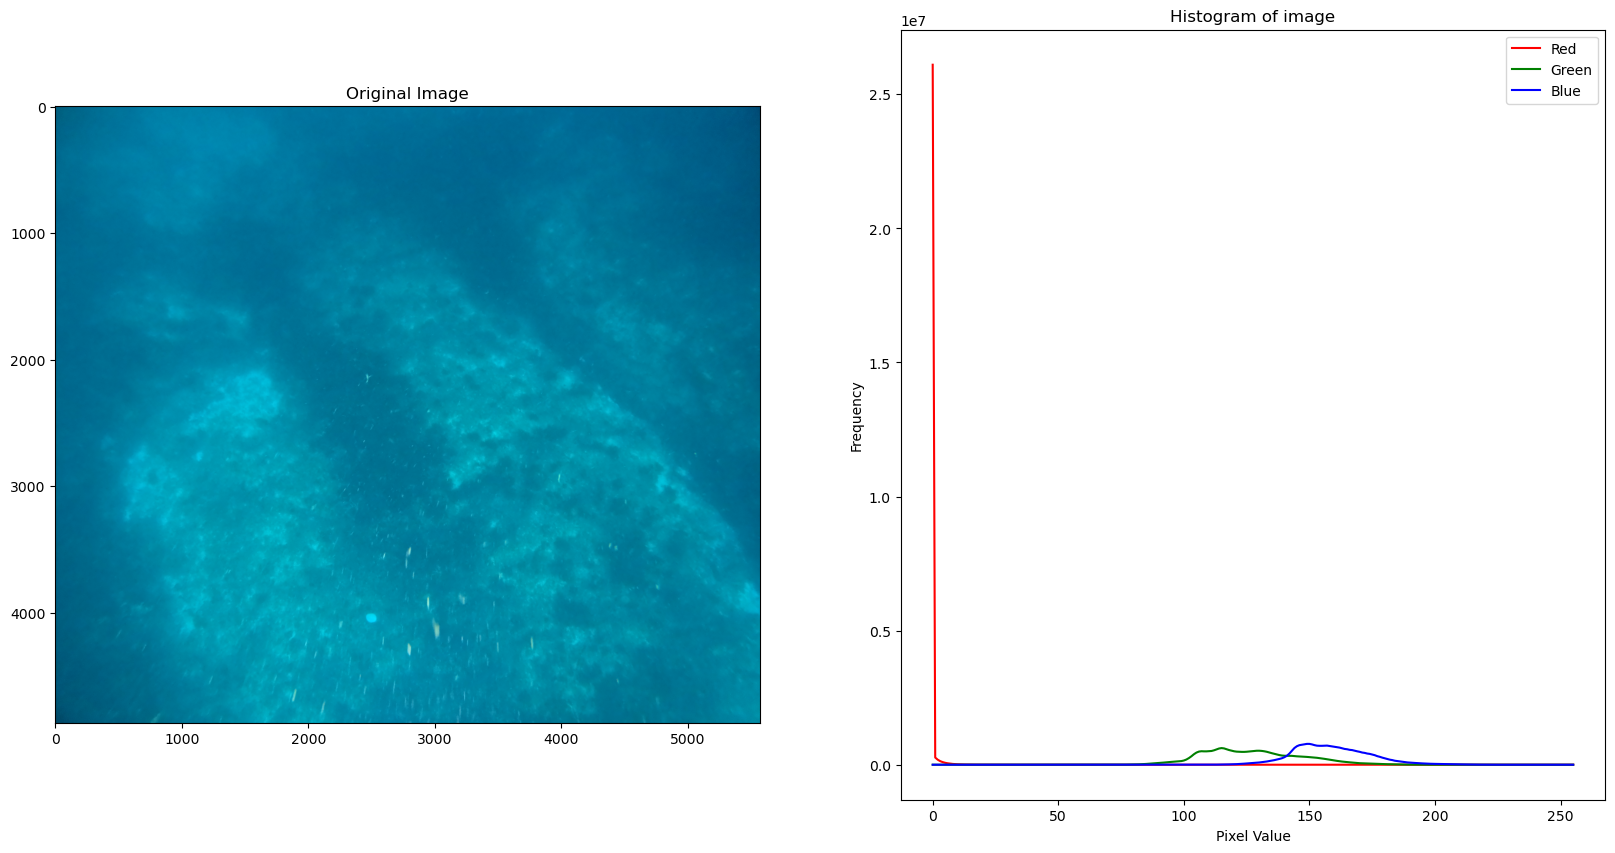

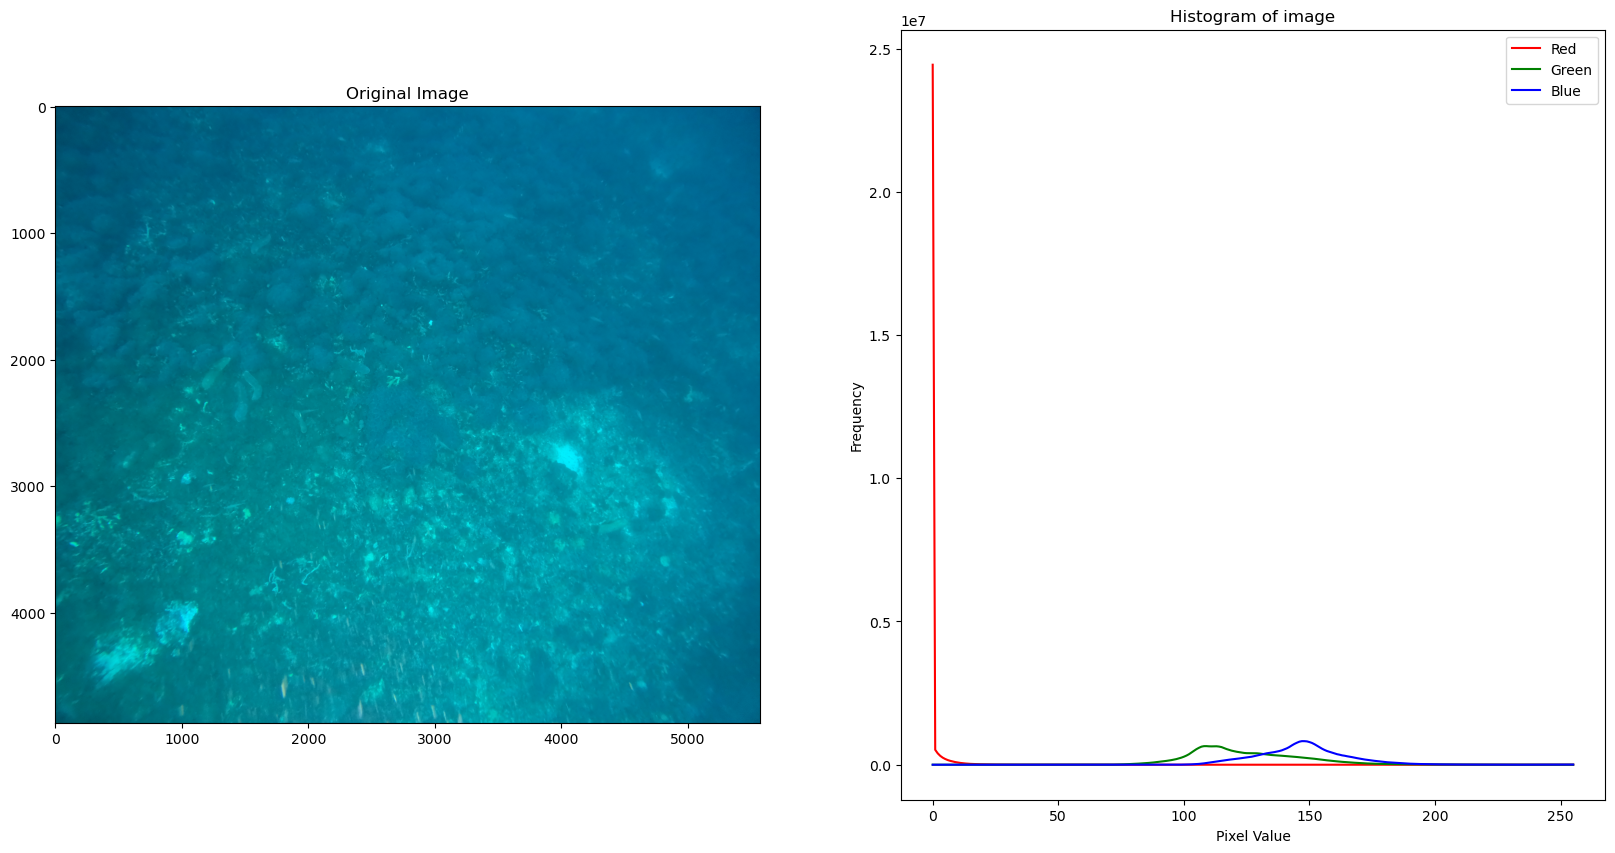

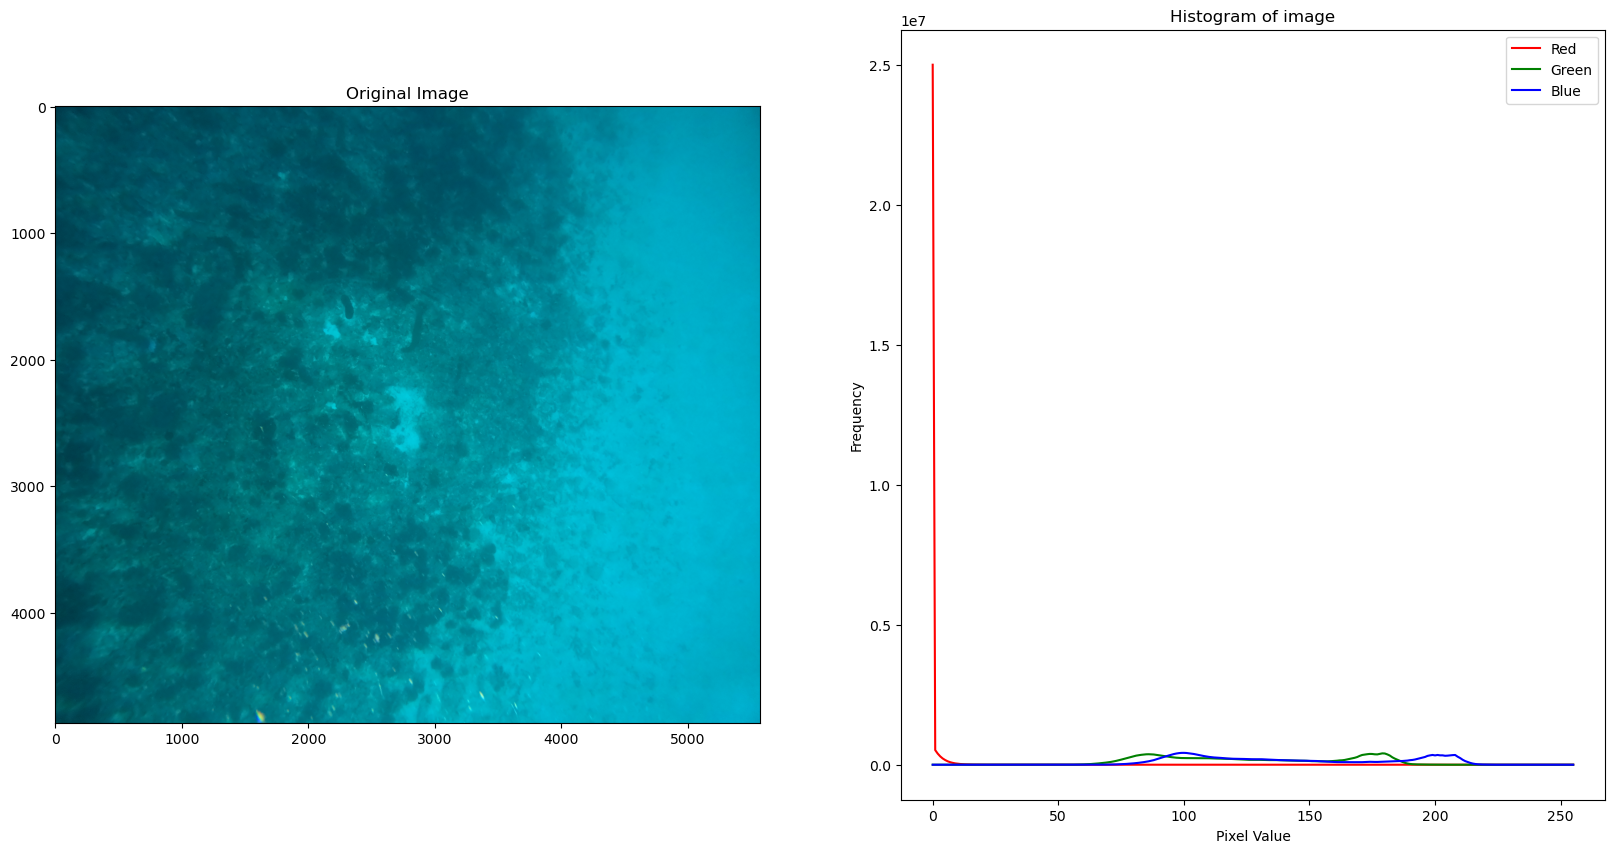

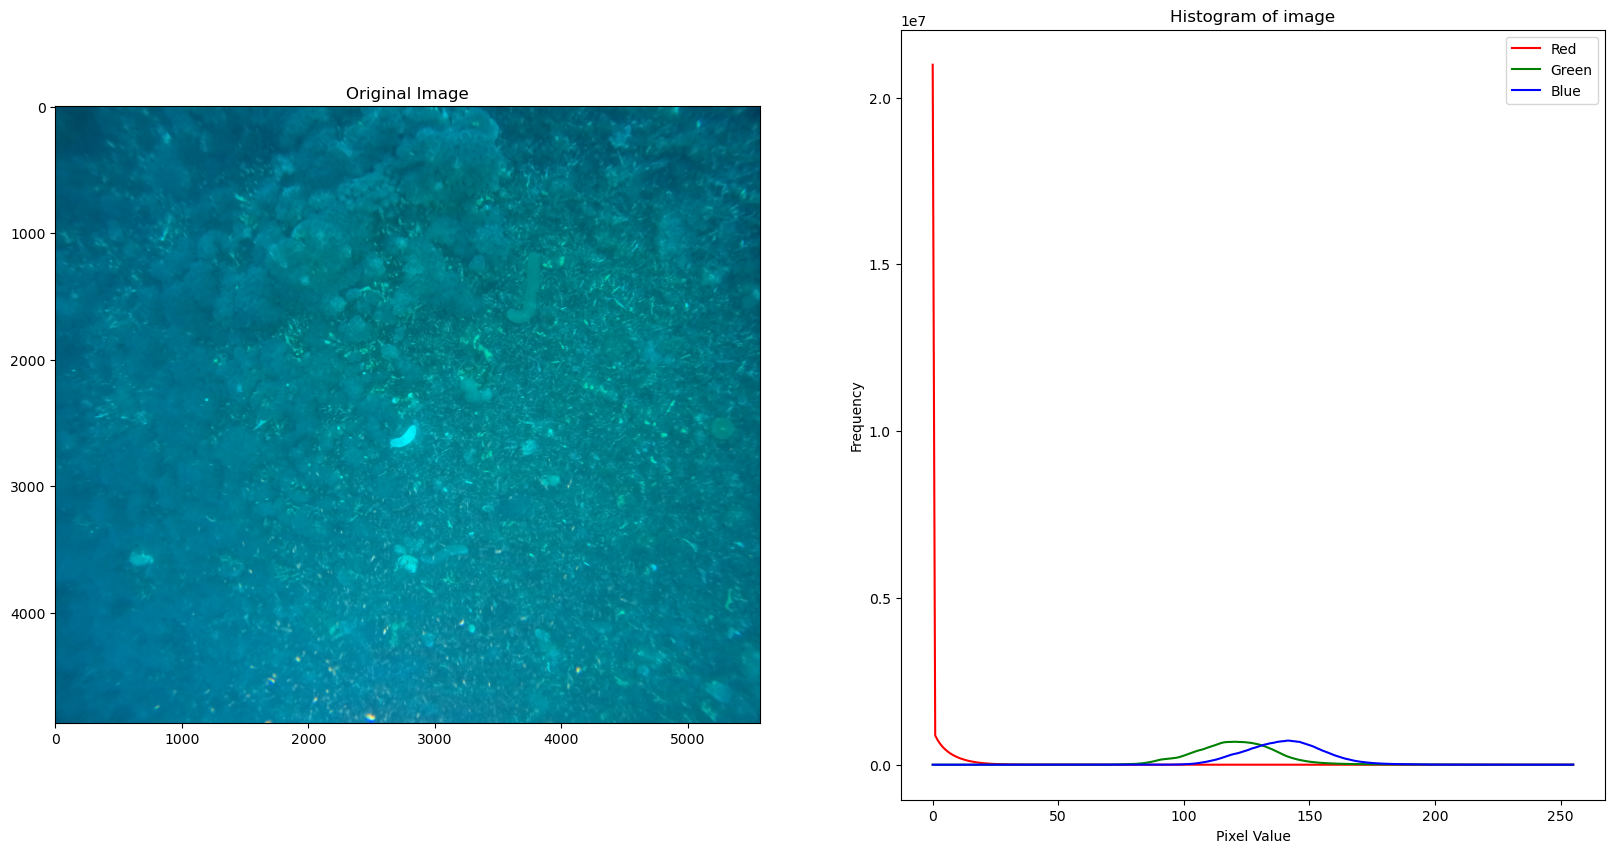

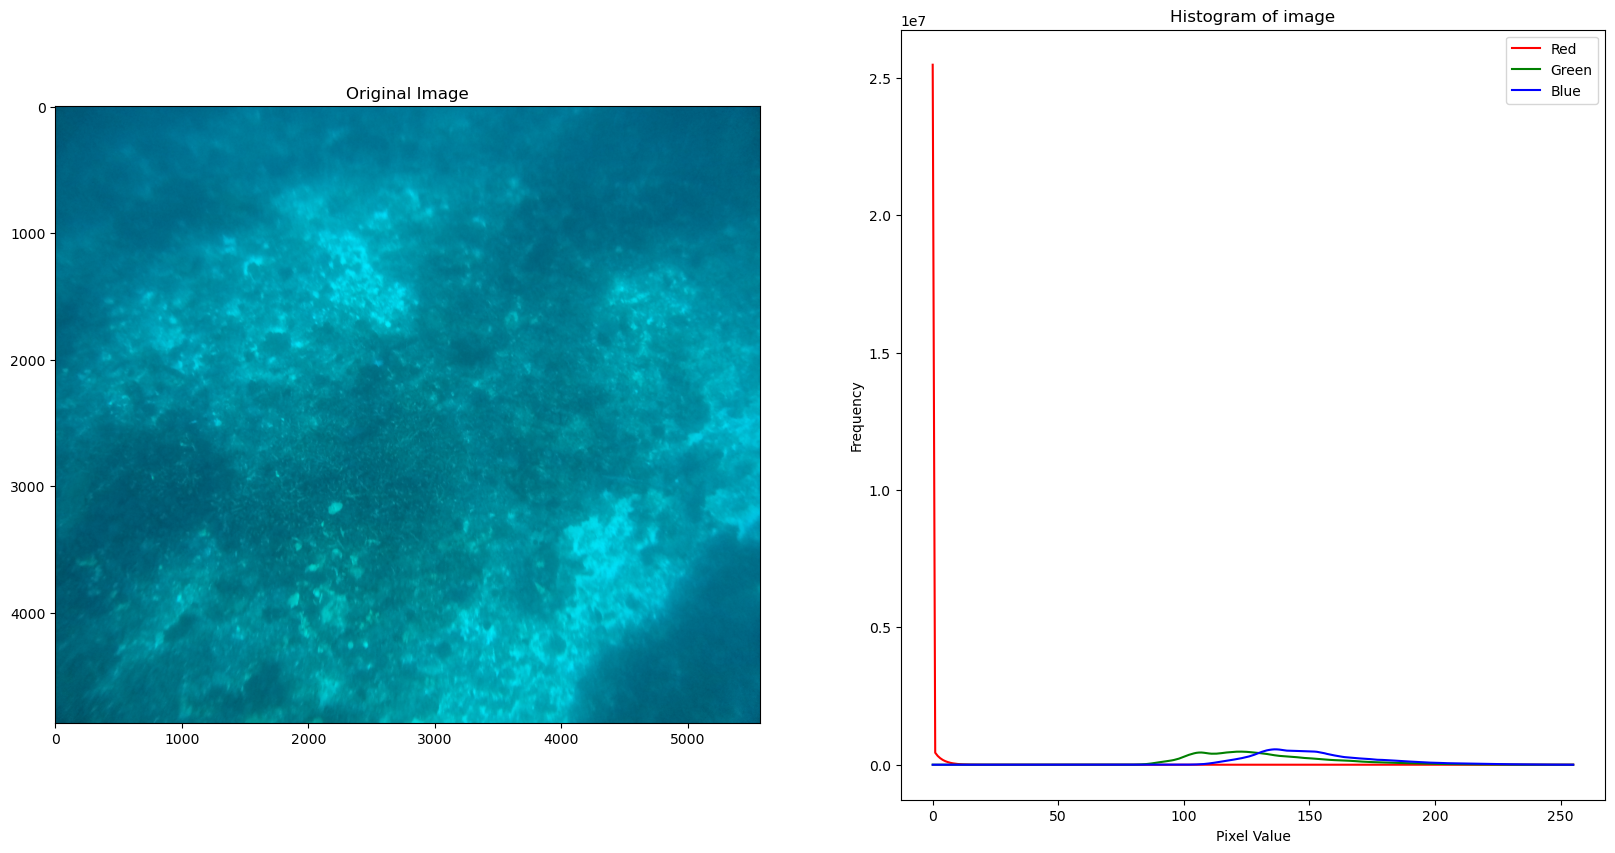

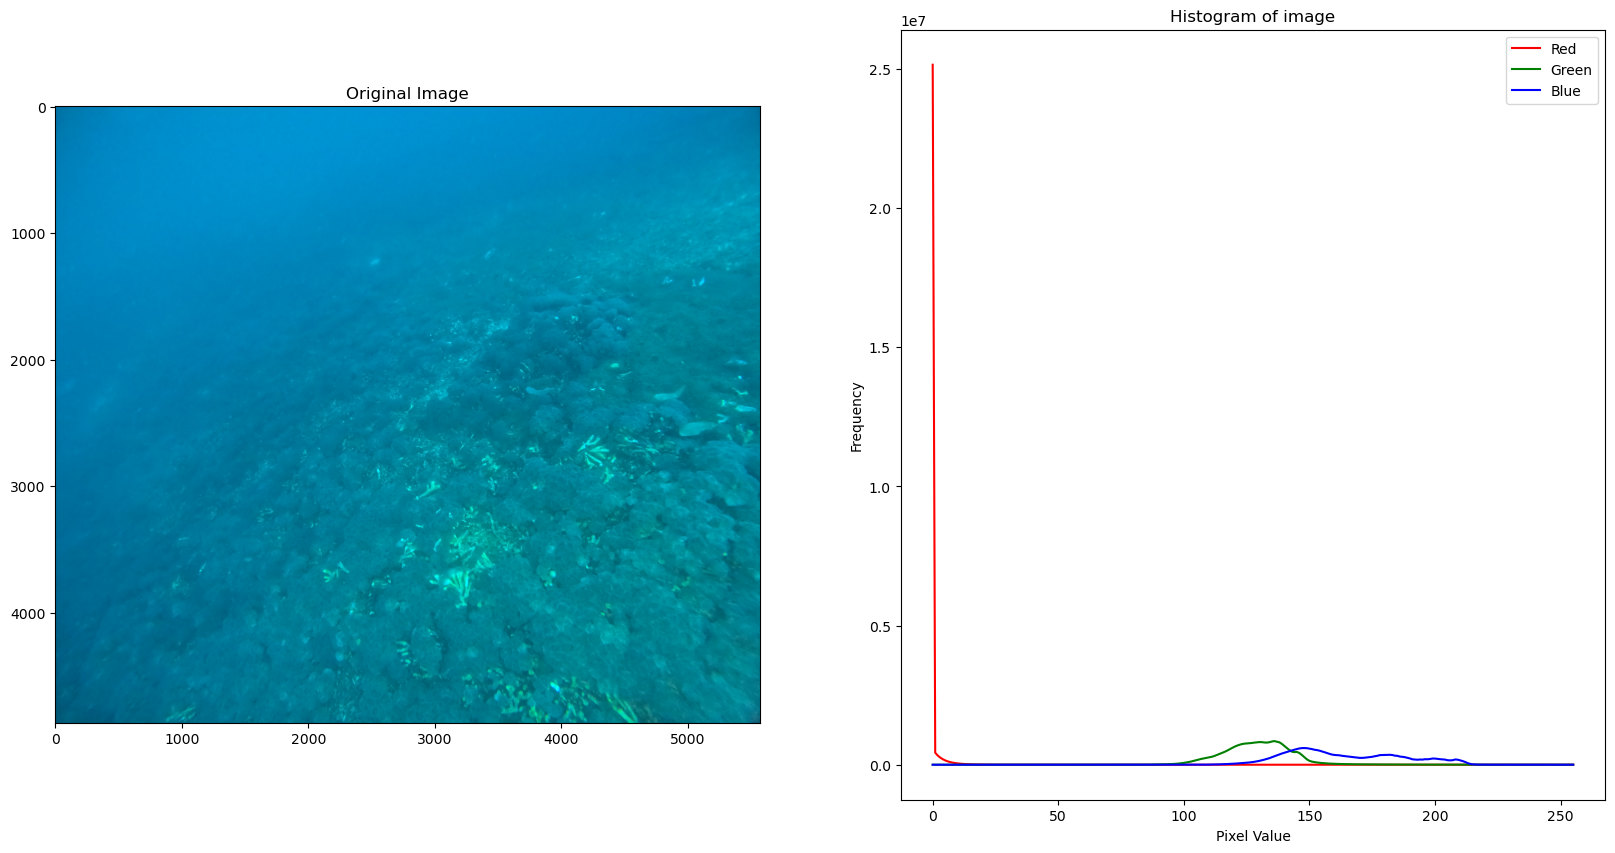

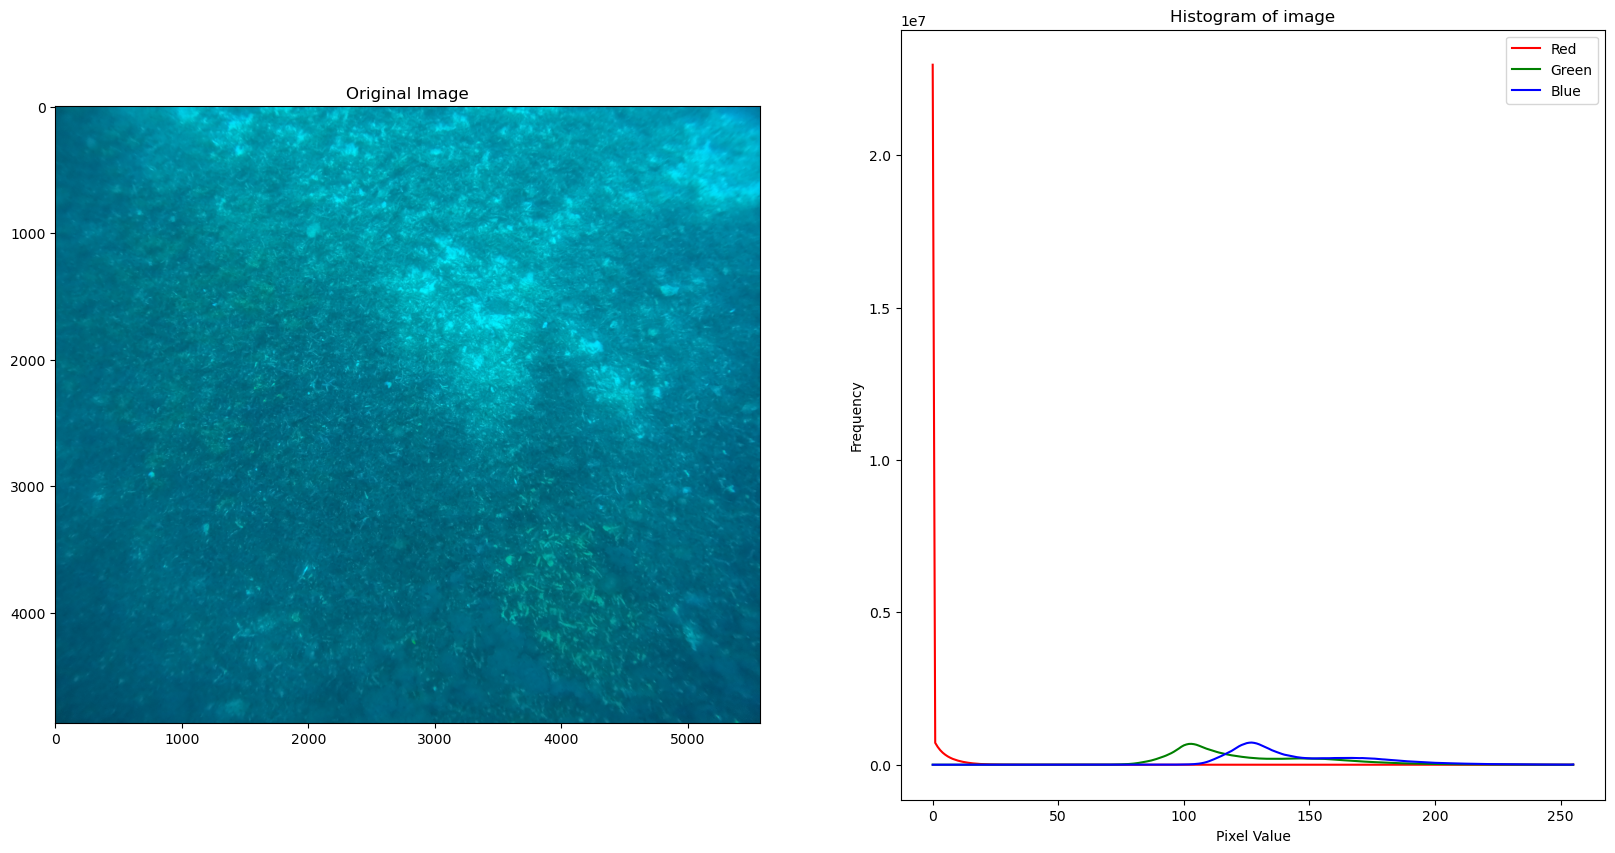

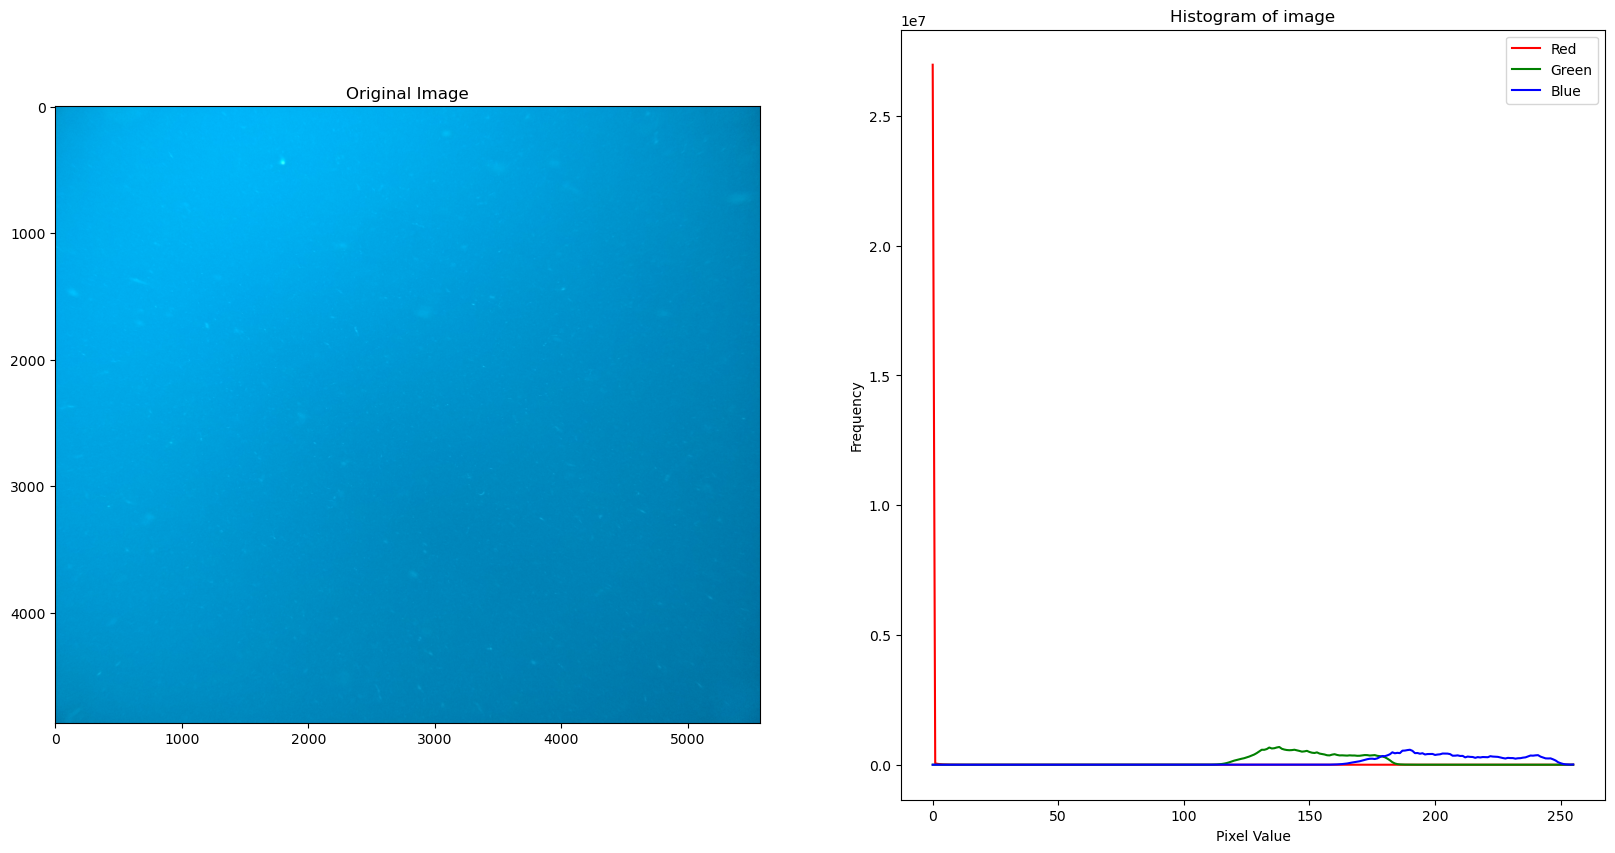

In [22]:
# Plotting the histograms of each channel of image
import os
from PIL import Image
from matplotlib import pyplot as plt

def plot_histogram(image):
    # Split the R, G and B channels
    imageR, imageG, imageB = image.split()
    
    # Plot the histograms
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Histogram of image")
    
    # Plot the histograms with labels
    plt.plot(imageR.histogram(), color='red', label='Red')
    plt.plot(imageG.histogram(), color='green', label='Green')
    plt.plot(imageB.histogram(), color='blue', label='Blue')
    
    # Add labels to the x and y axes
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    # Add a legend to indicate the color channels
    plt.legend()
    
    plt.show()

def process_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            plot_histogram(image)

if __name__ == "__main__":
    input_folder = (r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Bikini_test_raw")
    process_images_in_folder(input_folder)

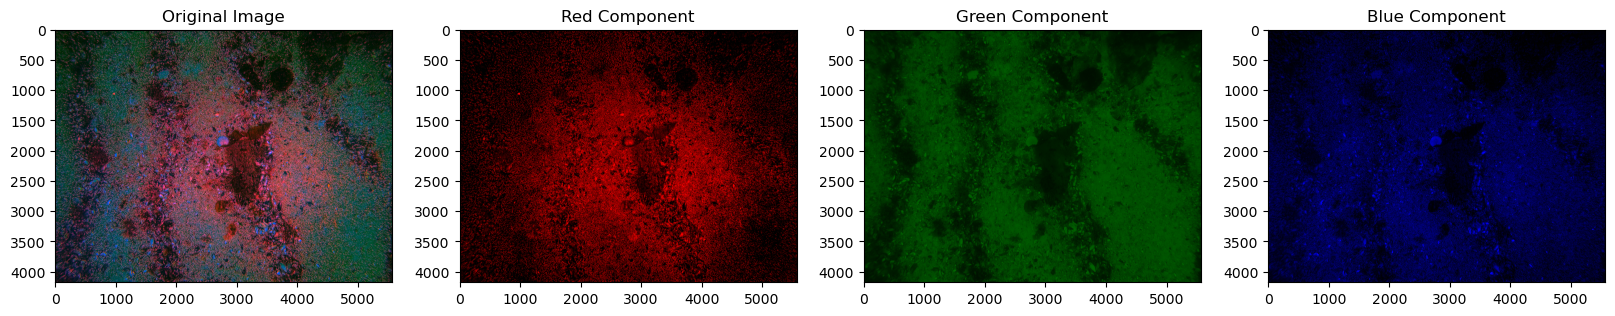

In [9]:
# Plotting R, G, and B components of the image
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

def channel_split(image):
    # Split the R, G, and B channels
    imageR, imageG, imageB = image.split()
    x, y = image.size
    Rchannel = np.zeros((y, x, 3), dtype="uint8")
    Bchannel = np.zeros((y, x, 3), dtype="uint8")
    Gchannel = np.zeros((y, x, 3), dtype="uint8")
    # Create individual components image
    Rchannel[:, :, 0] = imageR
    Bchannel[:, :, 1] = imageG
    Gchannel[:, :, 2] = imageB
    # Convert array to image
    Rchannel = Image.fromarray(Rchannel)
    Bchannel = Image.fromarray(Bchannel)
    Gchannel = Image.fromarray(Gchannel)

    # Plot R, G, and B components
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.subplot(1, 4, 2)
    plt.title("Red Component")
    plt.imshow(Rchannel)
    plt.subplot(1, 4, 3)
    plt.title("Green Component")
    plt.imshow(Bchannel)
    plt.subplot(1, 4, 4)
    plt.title("Blue Component")
    plt.imshow(Gchannel)
    plt.show()

def process_images_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".JPG") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            channel_split(image)

if __name__ == "__main__":
    input_folder = (r"Z:\\Personal\\Karl\\Auto_WB_\\Processed_Frames\\pranjalibajapi_complete_optimised_workflow\\Start_to_finish\\Test_4_processed\\Without_compensatinRB")
    process_images_in_folder(input_folder)